So first we restore our variables that we stored in `nb1`.

In [0]:
%store -r

In [0]:
%matplotlib inline
import os
from collections import Counter
from IPython.core.interactiveshell import InteractiveShell 
from tqdm import tqdm
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

In [0]:
InteractiveShell.ast_node_interactivity = "all"
path = "../../csv/Mercedes-Benz Greener Manufacturing/"

In [0]:
# This function calculates training and validation r2 scores by an estimator on a dataframe

def train_val_r2_score(estimator, X, y, n_splits=3, n_repeats=10, random_state=random_state):
    y_val_pred = pd.DataFrame(data=np.zeros(shape=(X.shape[0])),index=X.index, columns=['y'])
    scores = np.array([])
    train_scores = np.array([])
    for i in tqdm(range(n_repeats)):
        kf = KFold(n_splits=n_splits, random_state=random_state+i, shuffle=True)
        y_train_pred = pd.DataFrame(data=np.zeros(shape=(X.shape[0])),index=X.index, columns=['y'])
        for train_index, val_index in kf.split(X):
            X_ohe_train, X_ohe_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]
            _=estimator.fit(X_ohe_train, y_train)
            y_val_pred.iloc[val_index] = pd.DataFrame(estimator.predict(X_ohe_val), index=val_index, columns=['y'])
            y_train_pred.iloc[train_index] += pd.DataFrame(estimator.predict(X_ohe_train), index=train_index, columns=['y'])
        scores = np.append(scores, r2_score(y, y_val_pred))
        train_scores = np.append(train_scores, r2_score(y, y_train_pred/2))
    return scores, train_scores

def feature_search(feature, values, estimator, X, y, n_splits=3, n_repeats=10, random_state=random_state) : 
    val_scores = np.empty(shape=(len(values),n_repeats))
    train_scores = np.empty(shape=(len(values),n_repeats))
    for i in tqdm(range(len(values))):
        estimator.set_params(**{feature:values[i]})
        scores = train_val_r2_score(estimator, X, y)
        val_scores[i] = scores[0]
        train_scores[i] = scores[1]
    return val_scores, train_scores
 
def get_itrn(rf_d, X) : 
  interactions = []
  for tree in tqdm(rf_d.estimators_) : 
      for i in range(tree.tree_.node_count): 
          f1_index = tree.tree_.feature[i]
          f1 = X.columns[f1_index]
          f2_index = tree.tree_.feature[tree.tree_.children_left[i]]
          f2 = X.columns[f2_index]
          f3_index = tree.tree_.feature[tree.tree_.children_right[i]]
          f3 = X.columns[f3_index]
          if f1_index > 0 and f2_index > 0 : 
              interactions.append(','.join(sorted([f1, f2])))
          if f1_index > 0 and f3_index > 0 : 
              interactions.append(','.join(sorted([f1, f3])))
      interactions = list(set(interactions))
  return interactions


def get_itrn_dict(rf, X):
  interactions = {}
  for tree in tqdm(rf.estimators_) : 
    for i in range(tree.tree_.node_count):
          f1_index = tree.tree_.feature[i]
          f1 = X.columns[f1_index]
          f2_index = tree.tree_.feature[tree.tree_.children_left[i]]
          f2 = X.columns[f2_index]
          f3_index = tree.tree_.feature[tree.tree_.children_right[i]]
          f3 = X.columns[f3_index]
          if f1_index>0 and f2_index>0 : 
            feat = ','.join(sorted([f1, f2]))
            if feat in list(interactions.keys()): 
              interactions[feat] +=1
            else : 
              interactions[feat] = 1
          if f1_index>0 and f3_index>0 : 
            feat = ','.join(sorted([f1, f3]))
            if feat in list(interactions.keys()): 
              interactions[feat] +=1
            else : 
              interactions[feat] = 1
              
  return interactions


So now we will try to find out which feature are important from various importances that we calculated in `nb1`. 

In [5]:
var_df_ohe = pd.DataFrame(columns=['feature','variance'])
var_df_le = pd.DataFrame(columns=['feature','variance'])
for feat in tqdm(train_le.drop(['y','logy'], axis=1).columns):
    var_df_le.loc[var_df_le.shape[0],:] = list((feat, train_le[feat].var()))

for feat in tqdm(train_ohe.drop(['y','logy'], axis=1).columns):
    var_df_ohe.loc[var_df_ohe.shape[0],:] = list((feat, train_ohe[feat].var()))

var_df_ohe = var_df_ohe.sort_values(by='variance', axis=0).reset_index(drop=True)
var_df_le = var_df_le.sort_values(by='variance', axis=0).reset_index(drop=True)

100%|██████████| 507/507 [00:00<00:00, 592.65it/s]


Above we have calculated variance of each individual feature in both the encodings. This will help us in dropping features that have almost zero variance. From now on we will perform our analysis on one hot encoding and later we will check label encoding. 

Next we will try to find features which we can drop from our analysis

In [0]:
_,ax = plt.subplots(figsize=(20,100))
_=sns.barplot(x=list(feat_imp_ohe), y=list(feat_imp_ohe.index), ax=ax)


From above bar plot we can decide to drop features which have less importance. Let's add last 100 features to a list that we will drop. 

In [0]:
drop_feat_rf_ohe = []
drop_feat_rf_ohe.extend(list(feat_imp_ohe.index[:100]))

In [0]:
drop_feat_var_ohe = []
drop_feat_var_ohe.extend(list(var_df_ohe.iloc[:96].feature.values))

Here I have added those features to the list which have less than 10 ones in them and thus have a very low variance. 


In [0]:
drop_feat_anova = []
drop_feat_anova.extend(list(feat_imp_anova.loc[feat_imp_anova['p-value'] > 0.2, :].index))

Above we have added those features in removal list which have p-value > 0.2 which is quite a conservative p-value but it already covers more than 140 features. Let's now actually remove them one by one and see if we can get an improvement. 

First let's properly split our data into train and valid so that we get an honest estimate our test score. 

In [0]:
X_ohe = train_ohe.drop(['y','logy'], axis=1)
y = train_ohe['y']
logy = train_ohe['logy']
X_ohe_train, X_ohe_val, y_train, y_val = train_test_split(X_ohe, y, test_size=0.25, random_state=random_state+10)

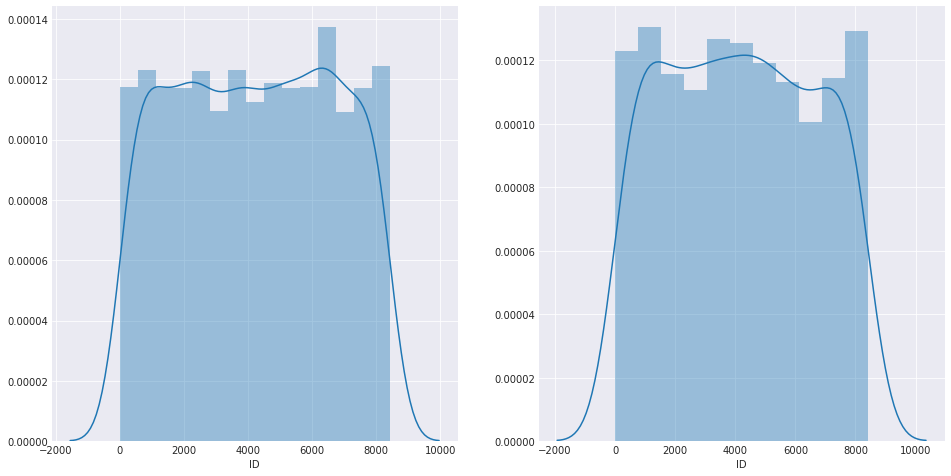

In [0]:
sns.set_style('darkgrid')
_,ax = plt.subplots(ncols=2, figsize=(16,8))
_=sns.distplot(X_ohe_train['ID'], ax=ax[0])
_=sns.distplot(X_ohe_val['ID'], ax=ax[1])

In [0]:
_,ax = plt.subplots(ncols=2, figsize=(16,8))
_=sns.pointplot(X_ohe_train.index.values, y=X_ohe_train.ID, ax=ax[0])
_=sns.pointplot(X_ohe_val.index.values, y=X_ohe_val.ID, ax=ax[1])

Here we can see that out train and validation have similar splitting as our train and test which we saw in last notebook.

In [0]:
rf = RandomForestRegressor(n_estimators=300, random_state=random_state, max_features='sqrt', n_jobs=-1)
_=rf.fit(X_ohe_train.drop(drop_feat_rf_ohe, axis=1), y_train)
y_pred = rf.predict(X_ohe_val.drop(drop_feat_rf_ohe, axis=1))

In [0]:
print (r2_score(y_val, y_pred))

0.573185931356


In [0]:
rf = RandomForestRegressor(n_estimators=300, random_state=random_state+1, max_features='sqrt', n_jobs=-1)
_=rf.fit(X_ohe_train.drop(drop_feat_anova, axis=1), y_train)
y_pred = rf.predict(X_ohe_val.drop(drop_feat_anova, axis=1))

In [0]:
print (r2_score(y_val, y_pred))

0.553080633174


In [0]:
rf = RandomForestRegressor(n_estimators=300, random_state=random_state+1, max_features='sqrt', n_jobs=-1)
_=rf.fit(X_ohe_train.drop(drop_feat_var_ohe, axis=1), y_train)
y_pred = rf.predict(X_ohe_val.drop(drop_feat_var_ohe, axis=1))

In [0]:
print (r2_score(y_val, y_pred))

0.570364124214


Now there seems to be some improvement in our `r2_score` by removing irrelevant features.So next we can try to merge the features in the 3 lists but first let's try to make a list of very important features from `feat_imp_ohe` so that we don't accidently drop any of the important feature. 


In [10]:
must_include_feat = list(feat_imp_ohe[-100:].index)
drop_feat = list(set(drop_feat_anova+drop_feat_rf_ohe+drop_feat_var_ohe))
drop_feat = [f for f in drop_feat if f not in must_include_feat]
len(drop_feat)

187

So overall we have shortlisted 187 features that we intend to drop from our model. Let's try random forest without these features. 

In [0]:
rf = RandomForestRegressor(n_estimators=300, random_state=random_state+1, max_features='sqrt', n_jobs=-1)
_=rf.fit(X_ohe_train.drop(drop_feat, axis=1), y_train)
y_pred = rf.predict(X_ohe_val.drop(drop_feat, axis=1))

In [0]:
print (r2_score(y_val, y_pred))

0.573761110922


Not much of improvement. :/ Anyway let's make a submission by training our model on full data. 

In [0]:
rf = RandomForestRegressor(n_estimators=300, random_state=random_state, max_features='sqrt', n_jobs=-1)
_=rf.fit(X_ohe.drop(drop_feat, axis=1), y)
y_pred = rf.predict(test_ohe.drop(drop_feat, axis=1))

In [0]:
subm = np.stack((test_ohe.ID.values, np.round(y_pred,5)), axis=1)
np.savetxt(path+'subm1.csv', subm, delimiter=',',header='ID,y', comments='', fmt=['%d','%.5f'])

The score on kaggle leaderboard is 0.537. Also if we train our random forest model on full data we have same r2 score on validation as we see in next cells. 

In [0]:
rf = RandomForestRegressor(n_estimators=300, random_state=random_state, max_features='sqrt', n_jobs=-1)
_=rf.fit(X_ohe_train, y_train)
y_pred = rf.predict(X_ohe_val)

In [0]:
print (r2_score(y_val, y_pred))

0.570456216929


Okay, So we saw there hasn't been much difference with or without dropping features. Also we see that there is difference between our scores and kaggle scores. So first lets fix that otherwise it is like blind experiment. 
First let's create a validation set whose r2 score we can trust. 

In [0]:
rf = RandomForestRegressor(n_estimators=300, random_state=random_state, max_features='sqrt', n_jobs=-1)
rkf = RepeatedKFold(n_splits=3, n_repeats=10, random_state=random_state)
cv_scores = cross_val_score(rf, X_ohe.drop(drop_feat, axis=1), y, cv=rkf, scoring='r2', n_jobs=-1)

In [0]:
cv_scores
cv_scores.std()
cv_scores.mean()

array([ 0.56707998,  0.53732899,  0.47411993,  0.54104993,  0.49531778,
        0.48241309,  0.50276032,  0.5004392 ,  0.53491152,  0.54277733,
        0.51143453,  0.513354  ,  0.58217038,  0.52755252,  0.4692895 ,
        0.46335293,  0.53793596,  0.55436884,  0.4600489 ,  0.54641549,
        0.54892853,  0.52900609,  0.53355275,  0.48977692,  0.51384895,
        0.52237338,  0.53518382,  0.5798326 ,  0.50960959,  0.47051461])

0.032929554669350825

0.51922494592349078

Here mean of `cv_scores` is close to what I have been been receving of leaderboard, but here also I have a standaed deviation of `0.032` which can make or break fortunes on kaggle. So assuming that our r2 score follows a normal distribution we can say with 68% confidence that out validation score will be somewhere between 0.487 to 0.551. Well that isn't very encouraging. 

Okay let's try to deduce r2 score from stacked predictions and see if we can reduce our standard deviation. 

In [0]:
rf = RandomForestRegressor(n_estimators=300, random_state=random_state, max_features='sqrt', n_jobs=-1)
rkf = RepeatedKFold(n_splits=3, n_repeats=10, random_state=random_state)
y_val_pred = pd.DataFrame(data=np.zeros(shape=(X_ohe.shape[0])),index=X_ohe.index, columns=['y'])
y_test_pred = pd.DataFrame(data=np.zeros(shape=(test_ohe.shape[0])),index=test_ohe.index, columns=['y'])
scores = np.array([])
for i in tqdm(range(10)):
    kf = KFold(n_splits=3, random_state=random_state+i, shuffle=True)
    for train_index, val_index in kf.split(X_ohe):
        X_ohe_train, X_ohe_val = X_ohe.iloc[train_index], X_ohe.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        _=rf.fit(X_ohe_train, y_train)
        y_val_pred.iloc[val_index] = pd.DataFrame(rf.predict(X_ohe_val), index=val_index, columns=['y'])
    scores = np.append(scores, r2_score(y, y_val_pred))


100%|██████████| 10/10 [01:41<00:00, 10.15s/it]


In [0]:
scores
scores.std()
scores.mean()

array([0.52125096, 0.50956363, 0.52007177, 0.50857688, 0.52467398,
       0.50616617, 0.51632671, 0.51659848, 0.51896283, 0.51158769])

0.0058091782489418905

0.5153779096749953

So here we have stacked our predictions from each fold and repeated it 10 times. As we see our standard deviation for r2 score has considerably decreased from 0.03 to 0.005 . Althoug after looking at leaderboard it still seems too much. Anyway first let's submit this model's prediction on test set. Later we can try adversarial validation to reduce our variation in r2 score. 

In [0]:
rf = RandomForestRegressor(n_estimators=300, random_state=random_state, max_features='sqrt', n_jobs=-1)
_=rf.fit(X_ohe, y)
y_test_pred = rf.predict(test_ohe)

In [0]:
np.savetxt(path+'subm0.csv', np.stack((test_ohe.ID.values, y_test_pred), axis=1), fmt=('%d', '%.8f'), delimiter=',',header='ID,y', comments='')

Okay so the results are exactly same as previous submission(because the models were exactly same) but at least we got our validation somewhat correct. If required we can try adversarial validation scheme. 

So now let's try to drop our irrelevant features and see if we can get an improvement. 

In [0]:
rf = RandomForestRegressor(n_estimators=300, random_state=random_state, max_features='sqrt', n_jobs=-1)
y_val_pred = pd.DataFrame(data=np.zeros(shape=(X_ohe.shape[0])),index=X_ohe.index, columns=['y'])
scores = np.array([])
for i in tqdm(range(10)):
    kf = KFold(n_splits=3, random_state=random_state+i, shuffle=True)
    for train_index, val_index in kf.split(X_ohe):
        X_ohe_train, X_ohe_val = X_ohe.iloc[train_index], X_ohe.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        _=rf.fit(X_ohe_train.drop(drop_feat_rf_ohe, axis=1), y_train)
        y_val_pred.iloc[val_index] = pd.DataFrame(rf.predict(X_ohe_val.drop(drop_feat_rf_ohe, axis=1)), index=val_index, columns=['y'])
    scores = np.append(scores, r2_score(y, y_val_pred))


100%|██████████| 10/10 [02:58<00:00, 17.82s/it]


In [0]:
scores
scores.std()
scores.mean()

array([ 0.52469023,  0.51038952,  0.52000114,  0.50992585,  0.52200599,
        0.50639532,  0.51714096,  0.51761645,  0.51849099,  0.51459845])

0.0054785986180002928

0.51612549209338554

In [0]:
rf = RandomForestRegressor(n_estimators=300, random_state=random_state, max_features='sqrt', n_jobs=-1)
y_val_pred = pd.DataFrame(data=np.zeros(shape=(X_ohe.shape[0])),index=X_ohe.index, columns=['y'])
scores = np.array([])
for i in tqdm(range(10)):
    kf = KFold(n_splits=3, random_state=random_state+i, shuffle=True)
    for train_index, val_index in kf.split(X_ohe):
        X_ohe_train, X_ohe_val = X_ohe.iloc[train_index], X_ohe.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        _=rf.fit(X_ohe_train.drop(drop_feat, axis=1), y_train)
        y_val_pred.iloc[val_index] = pd.DataFrame(rf.predict(X_ohe_val.drop(drop_feat, axis=1)), index=val_index, columns=['y'])
    scores = np.append(scores, r2_score(y, y_val_pred))


100%|██████████| 10/10 [03:21<00:00, 20.10s/it]


In [0]:
scores
scores.std()
scores.mean()

array([ 0.52328868,  0.51041776,  0.51995618,  0.50923922,  0.52227604,
        0.50803654,  0.51855599,  0.5189743 ,  0.51815384,  0.51493462])

0.0051781803028865181

0.51638331463503762

So in previous cells we have slightly improved our r2 score and compared to the one we submitted. Although standard deviation suggests that this tiny improvement could have been by chance. Anyway let's submit the predictions from both the models and see. 

In [0]:
rf = RandomForestRegressor(n_estimators=300, random_state=random_state, n_jobs=-1, max_features='sqrt')
_=rf.fit(X_ohe.drop(drop_feat_rf_ohe, axis=1), y)
y_test_pred = rf.predict(test_ohe.drop(drop_feat_rf_ohe, axis=1))

In [0]:
np.savetxt(path+'subm1.csv', np.stack((test_ohe.ID.values, y_test_pred), axis=1), fmt=('%d', '%.6f'), header='ID,y', comments='', delimiter=',')

In [0]:
rf = RandomForestRegressor(n_estimators=300, random_state=random_state, n_jobs=-1, max_features='sqrt')
_=rf.fit(X_ohe.drop(drop_feat, axis=1), y)
y_test_pred = rf.predict(test_ohe.drop(drop_feat, axis=1))

In [0]:
np.savetxt(path+'subm2.csv', np.stack((test_ohe.ID.values, y_test_pred), axis=1), fmt=('%d', '%.6f'), header='ID,y', comments='', delimiter=',')

Submitting `subm1` and `subm2` ended up having better scores and that validates our cross validation strategy. Also we will follow our own CV scores and submit the ones where our r2 score increases. 

Next let's try to tune hyperparameters like max_depth, max_features of our RandomForest model.

In [0]:
rf = RandomForestRegressor(n_estimators=300, random_state=random_state, max_features='sqrt', n_jobs=-1, max_depth=8)
y_val_pred = pd.DataFrame(data=np.zeros(shape=(X_ohe.shape[0])),index=X_ohe.index, columns=['y'])
scores = np.array([])
train_scores = np.array([])
for i in tqdm(range(10)):
    kf = KFold(n_splits=3, random_state=random_state+i, shuffle=True)
    y_train_pred = pd.DataFrame(data=np.zeros(shape=(X_ohe.shape[0])),index=X_ohe.index, columns=['y'])
    for train_index, val_index in kf.split(X_ohe):
        X_ohe_train, X_ohe_val = X_ohe.iloc[train_index], X_ohe.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        _=rf.fit(X_ohe_train.drop(drop_feat, axis=1), y_train)
        y_val_pred.iloc[val_index] = pd.DataFrame(rf.predict(X_ohe_val.drop(drop_feat, axis=1)), index=val_index, columns=['y'])
        y_train_pred.iloc[train_index] += pd.DataFrame(rf.predict(X_ohe_train.drop(drop_feat, axis=1)), index=train_index, columns=['y'])
    scores = np.append(scores, r2_score(y, y_val_pred))
    train_scores = np.append(train_scores, r2_score(y, y_train_pred/2))


100%|██████████| 10/10 [01:08<00:00,  6.83s/it]


In [0]:
scores
scores.std()
scores.mean()

train_scores
train_scores.std()
train_scores.mean()


array([ 0.54626595,  0.53802012,  0.54256989,  0.53682318,  0.54471775,
        0.53733475,  0.5447338 ,  0.54323792,  0.54162956,  0.53888661])

0.0032528105668075428

0.54142195320354003

array([ 0.624358  ,  0.62114289,  0.6208711 ,  0.62363008,  0.62126363,
        0.6240419 ,  0.62112681,  0.62242681,  0.61871165,  0.62194153])

0.0016332702277625641

0.62195144182585349

Lowering `max_depth` parameter in Random Forest model has surely improved results but let's find out the optimal value for `max_depth`. 

In [0]:
depths = [7,10,14,20]
n_splits= 3
n_repeats = 10
val_scores = np.empty(shape=(len(depths),n_repeats))
train_scores = np.empty(shape=(len(depths),n_repeats))
for i in tqdm(range(len(depths))):
    rf = RandomForestRegressor(n_estimators=300, random_state=random_state, max_features='sqrt', n_jobs=-1, max_depth=depths[i])
    scores = train_val_r2_score(rf, X_ohe.drop(drop_feat, axis=1), y, n_splits=n_splits, n_repeats=n_repeats)
    val_scores[i] = scores[0]
    train_scores[i] = scores[1]

100%|██████████| 4/4 [07:15<00:00, 108.88s/it]


In [0]:
val_scores.mean(axis=1)
val_scores.std(axis=1)
train_scores.mean(axis=1)
train_scores.std(axis=1)

array([ 0.53419057,  0.54785482,  0.54449841,  0.52989386])

array([ 0.00292482,  0.0037149 ,  0.00468874,  0.00495419])

array([ 0.59154402,  0.68166367,  0.78936023,  0.88914992])

array([ 0.00100826,  0.00109515,  0.00137449,  0.00095956])

Let's search more finer. 

In [0]:
depths = [9,10,12,13]
n_splits= 3
n_repeats = 10
val_scores = np.empty(shape=(len(depths),n_repeats))
train_scores = np.empty(shape=(len(depths),n_repeats))
for i in tqdm(range(len(depths))):
    rf = RandomForestRegressor(n_estimators=300, random_state=random_state, max_features='sqrt', n_jobs=-1, max_depth=depths[i])
    scores = train_val_r2_score(rf, X_ohe.drop(drop_feat, axis=1), y, n_splits=n_splits, n_repeats=n_repeats)
    val_scores[i] = scores[0]
    train_scores[i] = scores[1]

100%|██████████| 4/4 [06:10<00:00, 92.60s/it]


In [0]:
val_scores.mean(axis=1)
val_scores.std(axis=1)
train_scores.mean(axis=1)
train_scores.std(axis=1)

array([ 0.5464713 ,  0.54784952,  0.54782139,  0.54646169])

array([ 0.00339771,  0.00372271,  0.00394441,  0.00423574])

array([ 0.65265874,  0.68166401,  0.73936277,  0.76568685])

array([ 0.00172162,  0.00109486,  0.00096908,  0.0016723 ])

Looks like max_depth=10 is the optimal choice. Now let's tune max_features. 

In [0]:
features = [11, 14, 18, 24]
n_splits= 3
n_repeats = 10
val_scores = np.empty(shape=(len(features),n_repeats))
train_scores = np.empty(shape=(len(features),n_repeats))
for i in tqdm(range(len(features))):
    rf = RandomForestRegressor(n_estimators=300, random_state=random_state, max_features=features[i], n_jobs=-1, max_depth=10)
    scores = train_val_r2_score(rf, X_ohe.drop(drop_feat, axis=1), y, n_splits=n_splits, n_repeats=n_repeats)
    val_scores[i] = scores[0]
    train_scores[i] = scores[1]

100%|██████████| 4/4 [06:02<00:00, 90.64s/it]


In [0]:
val_scores.mean(axis=1)
val_scores.std(axis=1)
train_scores.mean(axis=1)
train_scores.std(axis=1)

array([ 0.53418758,  0.54364439,  0.54897413,  0.55359198])

array([ 0.0028894 ,  0.00293359,  0.00372951,  0.00411803])

array([ 0.65060869,  0.66873353,  0.68577367,  0.70294461])

array([ 0.00148938,  0.00168451,  0.00150092,  0.0015965 ])

So let's tune more as our optimal value is a corner value. 

In [0]:
features = [35, 40, 50]
n_splits= 3
n_repeats = 10
val_scores = np.empty(shape=(len(features),n_repeats))
train_scores = np.empty(shape=(len(features),n_repeats))
for i in tqdm(range(len(features))):
    rf = RandomForestRegressor(n_estimators=300, random_state=random_state, max_features=features[i], n_jobs=-1, max_depth=10)
    scores = train_val_r2_score(rf, X_ohe.drop(drop_feat, axis=1), y, n_splits=n_splits, n_repeats=n_repeats)
    val_scores[i] = scores[0]
    train_scores[i] = scores[1]

100%|██████████| 3/3 [10:02<00:00, 200.86s/it]


In [0]:
val_scores.mean(axis=1)
val_scores.std(axis=1)
train_scores.mean(axis=1)
train_scores.std(axis=1)

array([ 0.5561638 ,  0.55659849,  0.55635104])

array([ 0.0045554 ,  0.00455789,  0.00484248])

array([ 0.71996502,  0.72563362,  0.73231312])

array([ 0.00063284,  0.00123143,  0.00169095])

max_features=40 gives best result. Let's finetune around this value. 

In [0]:
features = [38, 42, 46]
n_splits= 3
n_repeats = 10
val_scores = np.empty(shape=(len(features),n_repeats))
train_scores = np.empty(shape=(len(features),n_repeats))
for i in tqdm(range(len(features))):
    rf = RandomForestRegressor(n_estimators=300, random_state=random_state, max_features=features[i], n_jobs=-1, max_depth=10)
    scores = train_val_r2_score(rf, X_ohe.drop(drop_feat, axis=1), y,train n_splits=n_splits, n_repeats=n_repeats)
    val_scores[i] = scores[0]
    train_scores[i] = scores[1]

100%|██████████| 3/3 [06:49<00:00, 136.59s/it]


In [0]:
val_scores.mean(axis=1)
val_scores.std(axis=1)
train_scores.mean(axis=1)
train_scores.std(axis=1)

array([ 0.556717  ,  0.55670292,  0.55656661])

array([ 0.00438882,  0.00482327,  0.00482623])

array([ 0.72326399,  0.72654537,  0.72897558])

array([ 0.00163706,  0.00131195,  0.00219448])

So let's use max_features=38 or any other close by value since the results vary a bit. 

Finally we have max_depth=10 and max_features=38. Let's fit a model and submit. 

In [0]:
rf = RandomForestRegressor(n_estimators=300, random_state=random_state, n_jobs=-1, max_features=38, max_depth=10)
_=rf.fit(X_ohe.drop(drop_feat, axis=1), y)
y_test_pred = rf.predict(test_ohe.drop(drop_feat, axis=1))

In [0]:
np.savetxt(path+'subm3.csv', np.stack((test_ohe.ID.values, y_test_pred), axis=1), fmt=('%d','%.6f'), delimiter=','
          , header='ID,y', comments='')

This submission significantly increases our r2 score on kaggle to 0.56237 on public LB and 0.54489 on private LB. 


## Feature Interactions

Next we will try to figure out frequent feature interactions and try to construct new features. 

In [0]:
rf_d = RandomForestRegressor(n_estimators=100, max_depth=8, n_jobs=-1, random_state=random_state)
_=rf_d.fit(X_ohe.drop(drop_feat, axis=1), y)

In [0]:
interactions = []
for tree in tqdm(rf_d.estimators_) : 
    for i in range(tree.tree_.node_count): 
        f1_index = tree.tree_.feature[i]
        f1 = X_ohe.drop(drop_feat, axis=1).columns[f1_index]
        f2_index = tree.tree_.feature[tree.tree_.children_left[i]]
        f2 = X_ohe.drop(drop_feat, axis=1).columns[f2_index]
        f3_index = tree.tree_.feature[tree.tree_.children_right[i]]
        f3 = X_ohe.drop(drop_feat, axis=1).columns[f3_index]
        if f1_index > 0 and f2_index > 0 : 
            interactions.append(','.join(sorted([f1, f2])))
        if f1_index > 0 and f3_index > 0 : 
            interactions.append(','.join(sorted([f1, f3])))
    interactions = list(set(interactions))
    

100%|██████████| 100/100 [10:40<00:00,  6.40s/it]


Here we trained another random forest model with only 100 estimators, max_depth=6, with max_features=auto(ie all features are considered while chosing best split). We could have done the same exercise with the previous random forest model(max_depth=10, n_estimators=100) but it would take too long to find all feature interactions. Even after reducing n_estimators and max_depth we can get feature interactions that matter the most. So let's now create features from these interactions and include them in training. 

In [0]:
X_ohe_itrn = X_ohe.drop(drop_feat, axis=1).copy()
test_ohe_itrn = test_ohe.drop(drop_feat, axis=1).copy()
for interaction in tqdm(interactions):
    f1 = interaction.split(',')[0]
    f2 = interaction.split(',')[1]
    X_ohe_itrn[interaction] = [str(X_ohe[f1][i])+str(X_ohe[f2][i]) for i in X_ohe.index]
    test_ohe_itrn[interaction] = [str(test_ohe[f1][i])+str(test_ohe[f2][i]) for i in test_ohe.index]



  0%|          | 7/4820 [00:02<24:51,  3.23it/s]
Exception in thread Thread-13:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

  2%|▏         | 113/4820 [00:35<24:25,  3.21it/s]

100%|██████████| 4820/4820 [27:15<00:00,  2.95it/s]


In [0]:
X_ohe_itrn = pd.get_dummies(X_ohe_itrn, columns=interactions)
test_ohe_itrn = pd.get_dummies(test_ohe_itrn, columns=interactions)

In [61]:
X_ohe_itrn.shape
test_ohe_itrn.shape

(4209, 2083)

(4209, 2072)

As we see the train dataframe(`X_ohe_itrn`) has more columns than in test(`test_ohe_itrn`). So let's diagnose this. 

In [0]:
col1 = [f for f in X_ohe_itrn.columns if f not in test_ohe_itrn]
print (len(col1))
col2 = [f for f in test_ohe_itrn.columns if f not in X_ohe_itrn]
print (len(col2))

111
78


So now we see that both `X_ohe_itrn` and `test_ohe_itrn` have columns not present in other. As we saw in notebook 1, we discard of columns from test(`test_ohe_itrn`) that aren't present in train(`X_ohe_itrn`) and introduce new columns in test(`test_ohe_itrn`) which are present in train(`X_ohe_itrn`). 

In [0]:
test_ohe_itrn = test_ohe_itrn.drop(col2, axis=1)
test_ohe_itrn = pd.concat([test_ohe_itrn, pd.DataFrame(np.zeros(( test_ohe_itrn.shape[0],len(col1))) , index=test_ohe_itrn.index, columns=col1) ], axis=1)

In [0]:
print (len([f for f in X_ohe_itrn.columns if f not in test_ohe_itrn.columns]))
print (len([f for f in test_ohe_itrn.columns if f not in X_ohe_itrn.columns]))


0
0


So having fixed our train and test data which have all the interactions in one hot encoded form. Now since our features have changed we need to tune our model once again. First let's find out how many estimators will be sufficient. 

In [0]:
X_ohe_itrn_train, X_ohe_itrn_val, y_train, y_val = train_test_split(X_ohe_itrn, y, test_size=0.3, shuffle=True, random_state=random_state)
rf_ohe_itrn = RandomForestRegressor(n_estimators=1000, max_features='sqrt', n_jobs=-1, random_state=random_state, max_depth=8)
_= rf_ohe_itrn.fit(X_ohe_itrn_train, y_train)
predictions_ohe_itrn = []
for tree in tqdm(rf_ohe_itrn.estimators_):
    predictions_ohe_itrn.append(tree.predict(X_ohe_itrn_val))
    cum_mean_ohe_itrn = np.cumsum(np.array(predictions_ohe_itrn), axis=0)/np.arange(1, np.array(predictions_ohe_itrn).shape[0]+1)[:,None]

100%|██████████| 1000/1000 [18:23<00:00,  1.10s/it]


100%|██████████| 1000/1000 [00:00<00:00, 5330.66it/s]
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


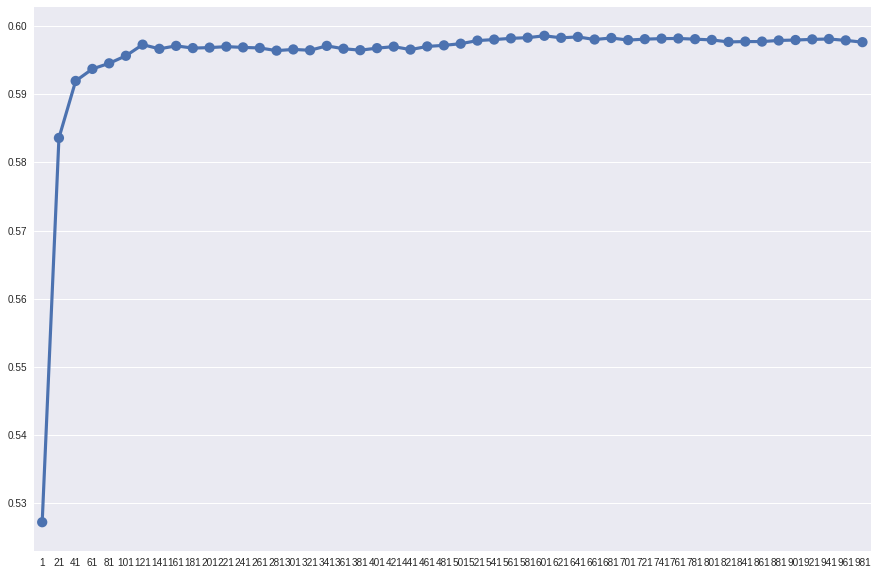

In [0]:
r2_scores_ohe = []
for y_pred in tqdm(cum_mean_ohe_itrn):
    r2_scores_ohe.append(r2_score(y_val, y_pred))
sns.set_style('darkgrid')
_,ax = plt.subplots(figsize=(15,10))
sns.pointplot(np.arange(1,cum_mean_ohe_itrn.shape[0]+1,20), [r2_scores_ohe[i] for i in list(np.arange(1,cum_mean_ohe_itrn.shape[0]+1,20))])

So the r2 scores plateau around 600. So let's choose n_estimators=600. Now that we have decided n_estimators let's try and tune max_features and max_depth. (In the next cell I have used n_estimators=200 and since it fives similar val_scores, we will use this only to reduce training time. )

In [0]:
rf_ohe_itrn = RandomForestRegressor(n_estimators=200, max_features='sqrt', n_jobs=-1, random_state=random_state, max_depth=8)
val_scores, train_scores = train_val_r2_score(rf_ohe_itrn, X_ohe_itrn, y)


  0%|          | 0/10 [00:00<?, ?it/s]
Exception in thread Thread-799:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 10/10 [05:12<00:00, 31.22s/it]


In [0]:
val_scores
val_scores.mean()
val_scores.std()

array([0.56101631, 0.55120399, 0.55833321, 0.55065942, 0.5616547 ,
       0.54930755, 0.55943614, 0.55872045, 0.55979684, 0.55802614])

0.5568154757496717

0.004358607874815607

Let's first try to optimise max_features. Also while trying different values we will use n_estimators=200 which we can increase before we create final model. 

In [0]:
max_feat = [205, 215]
rf_itrn = RandomForestRegressor(n_estimators=200, random_state=random_state, n_jobs=-1, max_depth=6)
val_scores, train_scores = feature_search('max_features', max_feat, rf_itrn, X_ohe_itrn, y)

100%|██████████| 2/2 [10:09<00:00, 304.98s/it]


In [0]:
val_scores.mean(axis=1)
val_scores.std(axis=1)


array([0.56076856, 0.5605692 ])

array([0.00395596, 0.00414307])

So max_features = 205 provide  best r2 score. Let's now focus on tuning max_depth. 

In [0]:
max_depth = [4,5,7]
rf_itrn = RandomForestRegressor(n_estimators=200, random_state=random_state, n_jobs=-1, max_features=205)
val_scores, train_scores = feature_search('max_depth', max_depth, rf_itrn, X_ohe_itrn, y)

100%|██████████| 10/10 [05:24<00:00, 32.44s/it]


100%|██████████| 3/3 [14:24<00:00, 288.26s/it]


In [0]:
val_scores.mean(axis=1)
val_scores.std(axis=1)


array([0.55596993, 0.56067435, 0.55899135])

array([0.0028911 , 0.00344105, 0.00505818])

So max_depth=5. Let's now train our model for higher n_estimators and check our r2 score. 

In [0]:
rf_ohe_itrn = RandomForestRegressor(n_estimators=600, max_features=205, n_jobs=-1, random_state=random_state, max_depth=5)
val_scores, train_scores = train_val_r2_score(rf_ohe_itrn, X_ohe_itrn, y)

In [0]:
val_scores.mean()

0.5608424402802508

Oky so now let's train a our random forest model on full dataset and submit predictions on test data 

In [0]:
rf_ohe_itrn = RandomForestRegressor(n_estimators=600, max_features=205, n_jobs=-1, random_state=random_state, max_depth=5)
_=rf_ohe_itrn.fit(X_ohe_itrn, y)
y_pred = rf_ohe_itrn.predict(test_ohe_itrn)

In [0]:
subm = np.stack((test_ohe.ID.values, np.round(y_pred,5)), axis=1)
np.savetxt('drive/app/subm4.csv', subm, delimiter=',',header='ID,y', comments='', fmt=['%d','%.5f'])

Okay something has gone wrong and our score nosedived on Kaggle. May be we used too many interaction terms and that ruined our model. 

## Interactions II

Okay so let's try taking only few interactions first see how it fares on kaggle. For selecting only important interactions we take max_depth=3 and max_features=38. 

In [0]:
rf_d = RandomForestRegressor(n_estimators=100, max_features=38, max_depth=3, random_state=random_state, n_jobs=-1)

_ = rf_d.fit(X_ohe.drop(drop_feat, axis=1), y)

In [24]:
interactions = []
for tree in tqdm(rf_d.estimators_) : 
    for i in range(tree.tree_.node_count): 
        f1_index = tree.tree_.feature[i]
        f1 = X_ohe.drop(drop_feat, axis=1).columns[f1_index]
        f2_index = tree.tree_.feature[tree.tree_.children_left[i]]
        f2 = X_ohe.drop(drop_feat, axis=1).columns[f2_index]
        f3_index = tree.tree_.feature[tree.tree_.children_right[i]]
        f3 = X_ohe.drop(drop_feat, axis=1).columns[f3_index]
        if f1_index > 0 and f2_index > 0 : 
            interactions.append(','.join(sorted([f1, f2])))
        if f1_index > 0 and f3_index > 0 : 
            interactions.append(','.join(sorted([f1, f3])))
    interactions = list(set(interactions))
    

100%|██████████| 100/100 [00:32<00:00,  3.09it/s]


In [58]:
X_ohe_itrn = X_ohe.drop(drop_feat, axis=1).copy()
test_ohe_itrn = test_ohe.drop(drop_feat, axis=1).copy()
for interaction in tqdm(interactions):
    f1 = interaction.split(',')[0]
    f2 = interaction.split(',')[1]
    X_ohe_itrn[interaction] = [str(X_ohe[f1][i])+str(X_ohe[f2][i]) for i in X_ohe.index]
    test_ohe_itrn[interaction] = [str(test_ohe[f1][i])+str(test_ohe[f2][i]) for i in test_ohe.index]


100%|██████████| 475/475 [01:47<00:00,  4.42it/s]


In [0]:
X_ohe_itrn = pd.get_dummies(X_ohe_itrn, columns=interactions)
test_ohe_itrn = pd.get_dummies(test_ohe_itrn, columns=interactions)

In [62]:
X_ohe_itrn.shape
test_ohe_itrn.shape

(4209, 2083)

(4209, 2072)

In [63]:
col1 = [f for f in X_ohe_itrn.columns if f not in test_ohe_itrn]
col2 = [f for f in test_ohe_itrn.columns if f not in X_ohe_itrn]
print (len(col1))
print (len(col2))

16
5


So there are 16 features which are present in `X_ohe_itrn` and not present in `test_ohe_itrn` and 5 features that are present in `test_ohe_itrn` and not present in `X_ohe_itrn`. So we will drop col2 from `test_ohe_itrn` and add col1 with all values as 0 in `test_ohe_itrn`. 

In [64]:
test_ohe_itrn = test_ohe_itrn.drop(col2, axis=1)
test_ohe_itrn = pd.concat([test_ohe_itrn, pd.DataFrame(np.zeros(( test_ohe_itrn.shape[0],len(col1))) , index=test_ohe_itrn.index, columns=col1) ], axis=1)
print (len([f for f in X_ohe_itrn.columns if f not in test_ohe_itrn]))
print (len([f for f in test_ohe_itrn.columns if f not in X_ohe_itrn]))

0
0


So now we have got our interaction features i both X_ohe_itrn and test_ohe_itrn so let's find out r2 score with these interaction features included. We will increase the max depth to our tuned value previously ie 10 and say n_estimators=400. 

In [29]:
rf = RandomForestRegressor(n_estimators=400, max_depth=10, max_features=38, n_jobs=-1, random_state=random_state)
val_scores, train_scores = train_val_r2_score(rf, X_ohe_itrn, y)

100%|██████████| 10/10 [01:50<00:00, 11.10s/it]


In [38]:
print (val_scores.mean())
print (val_scores.std())

0.5548351640606723
0.006727190096168585


In [0]:
rf = RandomForestRegressor(n_estimators=400, max_depth=10, max_features=38, n_jobs=-1, random_state=random_state, oob_score=True)
_=rf.fit(X_ohe_itrn, y)


In [35]:
print(rf.oob_score_)

0.5627847456543467


In [36]:
X_ohe_itrn.shape

(4209, 2083)

So here we have both oob_score and validation score using our `train_val_r2_score()` method. They give somewhat similat r2 scores. Now let's check for a suitable n_estimators that can give a stable score. 


In [54]:
X_ohe_itrn_train, X_ohe_itrn_val, y_train, y_val = train_test_split(X_ohe_itrn, y, test_size=0.3, shuffle=True, random_state=random_state)
rf_ohe_itrn = RandomForestRegressor(n_estimators=1000, max_features='sqrt', n_jobs=-1, random_state=random_state, max_depth=10)
_= rf_ohe_itrn.fit(X_ohe_itrn_train, y_train)
predictions_ohe_itrn = []
for tree in tqdm(rf_ohe_itrn.estimators_):
    predictions_ohe_itrn.append(tree.predict(X_ohe_itrn_val))
    mean_ohe_itrn = np.cumsum(np.array(predictions_ohe_itrn), axis=0)/np.arange(1, np.array(predictions_ohe_itrn).shape[0]+1)[:,None]

100%|██████████| 1000/1000 [02:09<00:00,  7.69it/s]


100%|██████████| 1000/1000 [00:00<00:00, 5517.42it/s]
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


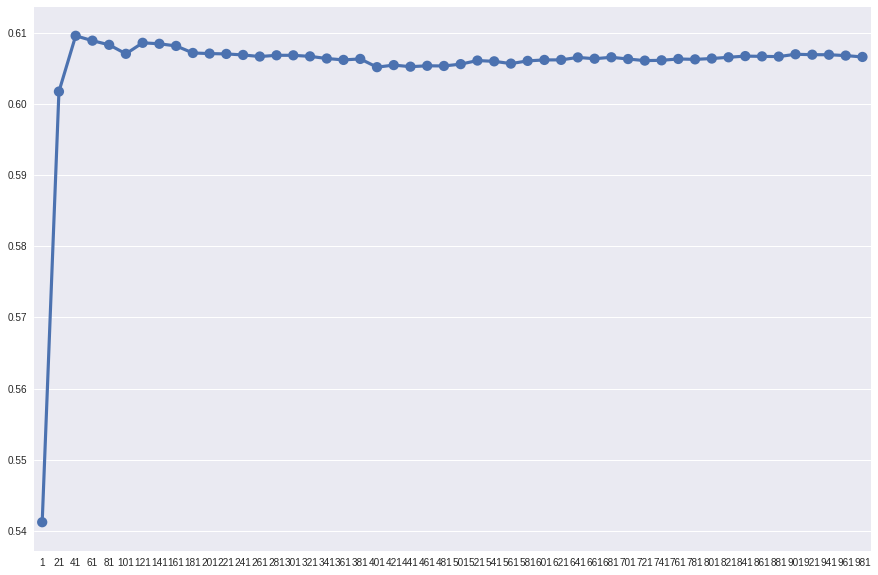

In [55]:
r2_scores_ohe = []
for y_pred in tqdm(cum_mean_ohe_itrn):
    r2_scores_ohe.append(r2_score(y_val, y_pred))
sns.set_style('darkgrid')
_,ax = plt.subplots(figsize=(15,10))
sns.pointplot(np.arange(1,mean_ohe_itrn.shape[0]+1,20), [r2_scores_ohe[i] for i in list(np.arange(1,mean_ohe_itrn.shape[0]+1,20))])

Okay so we have got r2 score stabilised around 500 estimators. Also let's further check if our `oob_score` complies. 


In [0]:
rf = RandomForestRegressor(n_estimators=500, max_depth=10, max_features='sqrt', oob_score=True, n_jobs=-1, random_state=random_state)
_=rf.fit(X_ohe_itrn, y)


In [57]:
rf.oob_score_

0.562349185633128

Okay so let's now predict `test_ohe_itrn` and submit. 

In [0]:
y_pred = rf.predict(test_ohe_itrn)

In [0]:
# uncomment the next line to set the path of your directory in which submission file is saved. 

path = 'drive/workspace/data/Merc/'

subm = np.stack((test_ohe_itrn.ID.values, y_pred), axis=1)
np.savetxt(path+'subm5.csv', subm, delimiter=',', header='ID,y', comments='', fmt=['%d','%.5f'])

So subm5 also gave poor results like before on kaggle. So may be we should calculate feature interactions only on train and calculate r2 score on a validation set. That will probably give a better picture.


## Interactions III

In [0]:
X_ohe_train, X_ohe_val, y_train, y_val = train_test_split(X_ohe, y, test_size=0.4, random_state=random_state, shuffle=True)
X_ohe_train.shape, X_ohe_val.shape, y_train.shape, y_val.shape



This time for finding features interactions we will use model trained only on X_ohe_train, y_train. 

In [0]:
rf_d = RandomForestRegressor(n_estimators=100, max_features=38, max_depth=3, random_state=random_state, n_jobs=-1)
_ = rf_d.fit(X_ohe_train.drop(drop_feat, axis=1), y_train)


In [100]:
interactions = get_itrn(rf_d, X_ohe_train.drop(drop_feat, axis=1))

100%|██████████| 100/100 [00:00<00:00, 6547.16it/s]


In [104]:
X_ohe_train_itrn = X_ohe_train.drop(drop_feat, axis=1).copy()
X_ohe_val_itrn = X_ohe_val.drop(drop_feat, axis=1).copy()
for interaction in tqdm(interactions):
    f1 = interaction.split(',')[0]
    f2 = interaction.split(',')[1]
    X_ohe_train_itrn[interaction] = [str(X_ohe_train[f1][i])+str(X_ohe_train[f2][i]) for i in X_ohe_train.index]
    X_ohe_val_itrn[interaction] = [str(X_ohe_val[f1][i])+str(X_ohe_val[f2][i]) for i in X_ohe_val.index]


100%|██████████| 483/483 [00:55<00:00,  8.76it/s]


In [0]:
X_ohe_train_itrn = pd.get_dummies(X_ohe_train_itrn, columns=interactions)
X_ohe_val_itrn = pd.get_dummies(X_ohe_val_itrn, columns=interactions)

In [171]:
X_ohe_train_itrn.shape
X_ohe_val_itrn.shape

(2525, 2116)

(1684, 2116)

In [109]:
col1 = [f for f in X_ohe_train_itrn.columns if f not in X_ohe_val_itrn.columns]
col2 = [f for f in X_ohe_val_itrn.columns if f not in X_ohe_train_itrn.columns]
print (len(col1))
print (len(col2))

31
3


In [110]:
X_ohe_val_itrn = X_ohe_val_itrn.drop(col2, axis=1)
X_ohe_val_itrn = pd.concat([X_ohe_val_itrn, pd.DataFrame(np.zeros(( X_ohe_val_itrn.shape[0],len(col1))) , index=X_ohe_val_itrn.index, columns=col1) ], axis=1)
print (len([f for f in X_ohe_train_itrn.columns if f not in X_ohe_val_itrn.columns]))
print (len([f for f in X_ohe_val_itrn.columns if f not in X_ohe_train_itrn.columns]))

0
0


In [0]:
rf = RandomForestRegressor(n_estimators=500, max_depth=10, max_features='sqrt', oob_score=True, n_jobs=-1, random_state=random_state)
_=rf.fit(X_ohe_train_itrn, y_train)

In [182]:
r2_score(y_val, rf.predict(X_ohe_val_itrn))

-0.23224794675836202

In [183]:
rf.oob_score_

0.5293562708225753

See here is the catch. In all the previous attempts we were calculating r2 score on the data which was already use din finding interactions and thus our estimate was highly optimistic. Now it reflects true r2 score as we saw on kaggle. Also we saw that `oob_score` is highly misleading(Reason why?). Let's try few things and see if it is beneficial at all to retain these features. 

In [136]:
feat_itrn = [f for f in X_ohe_train_itrn.columns if f not in X_ohe_train.drop(drop_feat, axis=1)]
len(feat_itrn)

1796

So there are 1796 new interaction features added. Let's pick only 200 features with highest variance. 

In [165]:
drop_itrn = list(X_ohe_train_itrn[feat_itrn].var().sort_values(ascending=False).index[:-200])
X_ohe_train_itrn.drop(drop_itrn, axis=1).shape

(2525, 520)

In [166]:
rf = RandomForestRegressor(n_estimators=500, max_depth=10, max_features='sqrt', oob_score=True, random_state=random_state, n_jobs=-1)
rf.fit(X_ohe_train_itrn.drop(drop_itrn, axis=1), y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=True, random_state=11, verbose=0, warm_start=False)

In [169]:
r2_score(y_val, rf.predict(X_ohe_val_itrn.drop(drop_itrn, axis=1)))

0.5708204556884335

Hmmmm... So now using just 200 interactions we have improved our r2 score on validation set. So let's first train on full data and submit on kaggle. Also instead of using the previous 200 interactions we will use full data to find new 200 interactions that have most variance on full data. 

## Submission

In [186]:
rf = RandomForestRegressor(n_estimators=200, max_depth=3, max_features='sqrt', oob_score=True, random_state=random_state, n_jobs=-1)
rf.fit(X_ohe.drop(drop_feat, axis=1), y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=True, random_state=11, verbose=0, warm_start=False)

In [187]:
interactions = get_itrn(rf, X_ohe.drop(drop_feat, axis=1))
len(interactions)

100%|██████████| 200/200 [00:00<00:00, 7260.85it/s]


1012

In [190]:
X_ohe_itrn = X_ohe.drop(drop_feat, axis=1).copy()
test_ohe_itrn = test_ohe.drop(drop_feat, axis=1).copy()
for interaction in tqdm(interactions):
    f1 = interaction.split(',')[0]
    f2 = interaction.split(',')[1]
    X_ohe_itrn[interaction] = [str(X_ohe[f1][i])+str(X_ohe[f2][i]) for i in X_ohe.index]
    test_ohe_itrn[interaction] = [str(test_ohe[f1][i])+str(test_ohe[f2][i]) for i in test_ohe.index]


100%|██████████| 1012/1012 [03:49<00:00,  4.40it/s]


In [0]:
X_ohe_itrn = pd.get_dummies(X_ohe_itrn, columns=interactions)
test_ohe_itrn = pd.get_dummies(test_ohe_itrn, columns=interactions)

In [193]:
X_ohe_itrn.shape
test_ohe_itrn.shape

(4209, 4119)

(4209, 4109)

In [199]:
col1 = [f for f in X_ohe_itrn.columns if f not in test_ohe_itrn.columns]
col2 = [f for f in test_ohe_itrn.columns if f not in X_ohe_itrn.columns]
print (len(col1))
print (len(col2))

26
0


In [200]:
test_ohe_itrn = test_ohe_itrn.drop(col2, axis=1)
test_ohe_itrn = pd.concat( ( test_ohe_itrn, pd.DataFrame(np.zeros( (test_ohe_itrn.shape[0], len(col1)) ), index=test_ohe_itrn.index, columns=col1)), axis=1)
print (len([f for f in X_ohe_itrn.columns if f not in test_ohe_itrn.columns]))
print (len([f for f in test_ohe_itrn.columns if f not in X_ohe_itrn.columns]))

0
0


In [209]:
itrn_feat = [f for f in X_ohe_itrn.columns if f not in X_ohe.drop(drop_feat, axis=1).columns]
len(itrn_feat)

3799

So let's select best 200 features from interaction features and use only them to train for submissions. 

In [218]:
drop_feat_itrn = X_ohe_itrn[itrn_feat].var().sort_values().index[:-200]
X_ohe_itrn.drop(drop_feat_itrn, axis=1).shape

(4209, 520)

In [220]:
rf = RandomForestRegressor(n_estimators=600, max_features='sqrt', max_depth=10, n_jobs=-1, random_state=random_state)
rf.fit(X_ohe_itrn.drop(drop_feat_itrn, axis=1), y)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=-1,
           oob_score=False, random_state=11, verbose=0, warm_start=False)

In [0]:
y_pred = rf.predict(test_ohe_itrn.drop(drop_feat_itrn, axis=1))

In [230]:
subm = np.stack((test_ohe_itrn.ID.values, y_pred), axis=1)
path
np.savetxt(path+'subm6.csv', subm, delimiter=',', header='ID,y', comments='', fmt=['%d','%.5f'])

'drive/workspace/data/Merc/'

So our Kaggle scores for this submission have been 0.54257 on private LB and 0.55927 on public LB. Let's see if we can increase our scores by changing the total no of interactions to include, max_depth, max_features. 

## Tune RF I

So herer we repeat same exercise with more interaction features to see if improve our score. 

In [22]:
X_ohe_train, X_ohe_val, y_train, y_val = train_test_split(X_ohe, y, test_size=0.4, random_state=random_state, shuffle=True)
X_ohe_train.shape, X_ohe_val.shape, y_train.shape, y_val.shape



((2525, 507), (1684, 507), (2525,), (1684,))

This time for finding features interactions we will use model trained only on X_ohe_train, y_train. 

In [0]:
rf_d = RandomForestRegressor(n_estimators=100, max_features=38, max_depth=3, random_state=random_state, n_jobs=-1)
_ = rf_d.fit(X_ohe_train.drop(drop_feat, axis=1), y_train)


In [24]:
interactions = get_itrn(rf_d, X_ohe_train.drop(drop_feat, axis=1))

100%|██████████| 100/100 [00:00<00:00, 6777.03it/s]


In [25]:
X_ohe_train_itrn = X_ohe_train.drop(drop_feat, axis=1).copy()
X_ohe_val_itrn = X_ohe_val.drop(drop_feat, axis=1).copy()
for interaction in tqdm(interactions):
    f1 = interaction.split(',')[0]
    f2 = interaction.split(',')[1]
    X_ohe_train_itrn[interaction] = [str(X_ohe_train[f1][i])+str(X_ohe_train[f2][i]) for i in X_ohe_train.index]
    X_ohe_val_itrn[interaction] = [str(X_ohe_val[f1][i])+str(X_ohe_val[f2][i]) for i in X_ohe_val.index]


100%|██████████| 483/483 [00:55<00:00,  8.65it/s]


In [0]:
X_ohe_train_itrn = pd.get_dummies(X_ohe_train_itrn, columns=interactions)
X_ohe_val_itrn = pd.get_dummies(X_ohe_val_itrn, columns=interactions)

In [27]:
X_ohe_train_itrn.shape
X_ohe_val_itrn.shape

(2525, 2116)

(1684, 2088)

In [28]:
col1 = [f for f in X_ohe_train_itrn.columns if f not in X_ohe_val_itrn.columns]
col2 = [f for f in X_ohe_val_itrn.columns if f not in X_ohe_train_itrn.columns]
print (len(col1))
print (len(col2))

31
3


In [29]:
X_ohe_val_itrn = X_ohe_val_itrn.drop(col2, axis=1)
X_ohe_val_itrn = pd.concat([X_ohe_val_itrn, pd.DataFrame(np.zeros(( X_ohe_val_itrn.shape[0],len(col1))) , index=X_ohe_val_itrn.index, columns=col1) ], axis=1)
print (len([f for f in X_ohe_train_itrn.columns if f not in X_ohe_val_itrn.columns]))
print (len([f for f in X_ohe_val_itrn.columns if f not in X_ohe_train_itrn.columns]))

0
0


So previously we checked for 200 interactions, now let check for more : 300. 

In [31]:
feat_itrn = [f for f in X_ohe_train_itrn.columns if f not in X_ohe_train.drop(drop_feat, axis=1)]
drop_itrn = list(X_ohe_train_itrn[feat_itrn].var().sort_values().index[:-300])
X_ohe_train_itrn.drop(drop_itrn, axis=1).shape

(2525, 620)

In [32]:
rf = RandomForestRegressor(n_estimators=500, max_depth=10, max_features='sqrt', oob_score=True, random_state=random_state, n_jobs=-1)
rf.fit(X_ohe_train_itrn.drop(drop_itrn, axis=1), y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=True, random_state=11, verbose=0, warm_start=False)

In [33]:
r2_score(y_val, rf.predict(X_ohe_val_itrn.drop(drop_itrn, axis=1)))

0.5893607787923212

Okay so our r2 score incereased let's try some other values : 
#### 150

In [34]:
drop_itrn = list(X_ohe_train_itrn[feat_itrn].var().sort_values().index[:-150])
X_ohe_train_itrn.drop(drop_itrn, axis=1).shape

(2525, 470)

In [35]:
rf = RandomForestRegressor(n_estimators=500, max_depth=10, max_features='sqrt', oob_score=True, random_state=random_state, n_jobs=-1)
rf.fit(X_ohe_train_itrn.drop(drop_itrn, axis=1), y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=True, random_state=11, verbose=0, warm_start=False)

In [36]:
r2_score(y_val, rf.predict(X_ohe_val_itrn.drop(drop_itrn, axis=1)))

0.5919943578936363

#### 500

In [37]:
drop_itrn = list(X_ohe_train_itrn[feat_itrn].var().sort_values().index[:-500])
X_ohe_train_itrn.drop(drop_itrn, axis=1).shape

(2525, 820)

In [38]:
rf = RandomForestRegressor(n_estimators=500, max_depth=10, max_features='sqrt', oob_score=True, random_state=random_state, n_jobs=-1)
rf.fit(X_ohe_train_itrn.drop(drop_itrn, axis=1), y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=True, random_state=11, verbose=0, warm_start=False)

In [39]:
r2_score(y_val, rf.predict(X_ohe_val_itrn.drop(drop_itrn, axis=1)))

0.5831966178573903

#### 600

In [40]:
drop_itrn = list(X_ohe_train_itrn[feat_itrn].var().sort_values().index[:-600])
X_ohe_train_itrn.drop(drop_itrn, axis=1).shape

(2525, 920)

In [41]:
rf = RandomForestRegressor(n_estimators=500, max_depth=10, max_features='sqrt', oob_score=True, random_state=random_state, n_jobs=-1)
rf.fit(X_ohe_train_itrn.drop(drop_itrn, axis=1), y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=True, random_state=11, verbose=0, warm_start=False)

In [42]:
r2_score(y_val, rf.predict(X_ohe_val_itrn.drop(drop_itrn, axis=1)))

0.5820892060060414

SO we see that higher than 300 the value decreases. Let's try more values below 200. 

#### 100 

In [43]:
drop_itrn = list(X_ohe_train_itrn[feat_itrn].var().sort_values().index[:-100])
X_ohe_train_itrn.drop(drop_itrn, axis=1).shape

(2525, 420)

In [44]:
rf = RandomForestRegressor(n_estimators=500, max_depth=10, max_features='sqrt', oob_score=True, random_state=random_state, n_jobs=-1)
rf.fit(X_ohe_train_itrn.drop(drop_itrn, axis=1), y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=True, random_state=11, verbose=0, warm_start=False)

In [45]:
r2_score(y_val, rf.predict(X_ohe_val_itrn.drop(drop_itrn, axis=1)))

0.5923512529028498

#### 50

In [46]:
drop_itrn = list(X_ohe_train_itrn[feat_itrn].var().sort_values().index[:-50])
X_ohe_train_itrn.drop(drop_itrn, axis=1).shape

(2525, 370)

In [47]:
rf = RandomForestRegressor(n_estimators=500, max_depth=10, max_features='sqrt', oob_score=True, random_state=random_state, n_jobs=-1)
rf.fit(X_ohe_train_itrn.drop(drop_itrn, axis=1), y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=True, random_state=11, verbose=0, warm_start=False)

In [48]:
r2_score(y_val, rf.predict(X_ohe_val_itrn.drop(drop_itrn, axis=1)))

0.5927677813603701

#### 40

In [55]:
drop_itrn = list(X_ohe_train_itrn[feat_itrn].var().sort_values().index[:-40])
X_ohe_train_itrn.drop(drop_itrn, axis=1).shape

(2525, 360)

In [56]:
rf = RandomForestRegressor(n_estimators=500, max_depth=10, max_features='sqrt', oob_score=True, random_state=random_state, n_jobs=-1)
rf.fit(X_ohe_train_itrn.drop(drop_itrn, axis=1), y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=True, random_state=11, verbose=0, warm_start=False)

In [57]:
r2_score(y_val, rf.predict(X_ohe_val_itrn.drop(drop_itrn, axis=1)))

0.5915455208645717

#### 60

In [58]:
drop_itrn = list(X_ohe_train_itrn[feat_itrn].var().sort_values().index[:-60])
X_ohe_train_itrn.drop(drop_itrn, axis=1).shape

(2525, 380)

In [59]:
rf = RandomForestRegressor(n_estimators=500, max_depth=10, max_features='sqrt', oob_score=True, random_state=random_state, n_jobs=-1)
rf.fit(X_ohe_train_itrn.drop(drop_itrn, axis=1), y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=True, random_state=11, verbose=0, warm_start=False)

In [60]:
r2_score(y_val, rf.predict(X_ohe_val_itrn.drop(drop_itrn, axis=1)))

0.5913091656710152

So as we see that around 50 interactions provide the best score. Let's submit and see if we improved on leaderboard. 

## Submission

In [61]:
rf = RandomForestRegressor(n_estimators=200, max_depth=3, max_features='sqrt', oob_score=True, random_state=random_state, n_jobs=-1)
rf.fit(X_ohe.drop(drop_feat, axis=1), y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=True, random_state=11, verbose=0, warm_start=False)

In [62]:
interactions = get_itrn(rf, X_ohe.drop(drop_feat, axis=1))
len(interactions)

100%|██████████| 200/200 [00:00<00:00, 7102.55it/s]


1012

In [63]:
X_ohe_itrn = X_ohe.drop(drop_feat, axis=1).copy()
test_ohe_itrn = test_ohe.drop(drop_feat, axis=1).copy()
for interaction in tqdm(interactions):
    f1 = interaction.split(',')[0]
    f2 = interaction.split(',')[1]
    X_ohe_itrn[interaction] = [str(X_ohe[f1][i])+str(X_ohe[f2][i]) for i in X_ohe.index]
    test_ohe_itrn[interaction] = [str(test_ohe[f1][i])+str(test_ohe[f2][i]) for i in test_ohe.index]


100%|██████████| 1012/1012 [03:55<00:00,  4.30it/s]


In [0]:
X_ohe_itrn = pd.get_dummies(X_ohe_itrn, columns=interactions)
test_ohe_itrn = pd.get_dummies(test_ohe_itrn, columns=interactions)

In [66]:
X_ohe_itrn.shape
test_ohe_itrn.shape

(4209, 4119)

(4209, 4109)

In [67]:
col1 = [f for f in X_ohe_itrn.columns if f not in test_ohe_itrn.columns]
col2 = [f for f in test_ohe_itrn.columns if f not in X_ohe_itrn.columns]
print (len(col1))
print (len(col2))

26
16


In [68]:
test_ohe_itrn = test_ohe_itrn.drop(col2, axis=1)
test_ohe_itrn = pd.concat( ( test_ohe_itrn, pd.DataFrame(np.zeros( (test_ohe_itrn.shape[0], len(col1)) ), index=test_ohe_itrn.index, columns=col1)), axis=1)
print (len([f for f in X_ohe_itrn.columns if f not in test_ohe_itrn.columns]))
print (len([f for f in test_ohe_itrn.columns if f not in X_ohe_itrn.columns]))

0
0


So let's select best 50 features from interaction features and use only them to train for submissions. 

In [69]:
itrn_feat = [f for f in X_ohe_itrn.columns if f not in X_ohe.drop(drop_feat, axis=1).columns]
drop_feat_itrn = X_ohe_itrn[itrn_feat].var().sort_values().index[:-50]
X_ohe_itrn.drop(drop_feat_itrn, axis=1).shape

(4209, 370)

In [70]:
rf = RandomForestRegressor(n_estimators=600, max_features='sqrt', max_depth=10, n_jobs=-1, random_state=random_state)
rf.fit(X_ohe_itrn.drop(drop_feat_itrn, axis=1), y)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=-1,
           oob_score=False, random_state=11, verbose=0, warm_start=False)

In [0]:
y_pred = rf.predict(test_ohe_itrn.drop(drop_feat_itrn, axis=1))

In [0]:
subm = np.stack((test_ohe_itrn.ID.values, y_pred), axis=1)
path = "drive/workspace/data/Merc/"
np.savetxt(path+'subm7.csv', subm, delimiter=',', header='ID,y', comments='', fmt=['%d','%.5f'])

Score on public LB=0.56189 and on private LB=0.54400. This score is still behind best tuned RF model without interactions. Let's now tune max_features. 

## Tune RF II



100%|██████████| 3/3 [03:28<00:00, 69.57s/it]

In [83]:
val_scores.mean(axis=1)
train_scores.mean(axis=1)

array([0.55692065, 0.55732839, 0.55697312])

array([0.70735592, 0.71686477, 0.7270577 ])

In [86]:
max_feat = [18, 21]
rf = RandomForestRegressor(n_estimators=600, max_depth=10, n_jobs=-1, random_state=random_state)
val_scores, train_scores = feature_search('max_features', max_feat, rf, X_ohe_itrn.drop(drop_feat_itrn, axis=1), y)

100%|██████████| 2/2 [02:38<00:00, 79.40s/it]


In [87]:
val_scores.mean(axis=1)
train_scores.mean(axis=1)

array([0.55709546, 0.55731644])

array([0.71445686, 0.7209025 ])

So it seems like max_features=19 gives best scores. Now lets tune max_depth. 

In [88]:
max_depth = [7, 12]
rf = RandomForestRegressor(n_estimators=500, max_features=19, n_jobs=-1, random_state=random_state)
val_scores, train_scores = feature_search('max_depth', max_depth, rf, X_ohe_itrn.drop(drop_feat_itrn, axis=1), y)

100%|██████████| 2/2 [02:12<00:00, 66.28s/it]


In [89]:
val_scores.mean(axis=1)
train_scores.mean(axis=1)

array([0.5600061 , 0.55237231])

array([0.63278873, 0.77230074])

In [90]:
max_depth = [7, 10]
rf = RandomForestRegressor(n_estimators=600, max_features=19, n_jobs=-1, random_state=random_state)
val_scores, train_scores = feature_search('max_depth', max_depth, rf, X_ohe_itrn.drop(drop_feat_itrn, axis=1), y)

100%|██████████| 2/2 [02:20<00:00, 70.08s/it]


In [91]:
val_scores.mean(axis=1)
train_scores.mean(axis=1)

array([0.55996873, 0.55737009])

array([0.63273541, 0.71656187])

In [92]:
max_depth = [5, 8]
rf = RandomForestRegressor(n_estimators=600, max_features=19, n_jobs=-1, random_state=random_state)
val_scores, train_scores = feature_search('max_depth', max_depth, rf, X_ohe_itrn.drop(drop_feat_itrn, axis=1), y)

100%|██████████| 2/2 [02:00<00:00, 60.18s/it]


In [93]:
val_scores.mean(axis=1)
train_scores.mean(axis=1)

array([0.55409974, 0.55995536])

array([0.58483246, 0.65995846])

So max_depth =7 provides best score let's see whether we can improve of we grow full trees. 

In [94]:
rf = RandomForestRegressor(n_estimators=600, max_features=19, n_jobs=-1, random_state=random_state)
val_scores, train_scores = train_val_r2_score(rf, X_ohe_itrn.drop(drop_feat_itrn, axis=1), y)

100%|██████████| 10/10 [02:51<00:00, 17.12s/it]


In [96]:
val_scores.mean()
train_scores.mean()

0.5206548236154952

0.9371104472572724

So let's keep max_depth=7 and prepare final submission. 

## Submission

In [97]:
rf = RandomForestRegressor(n_estimators=600, max_features=19, max_depth=7, n_jobs=-1, random_state=random_state)
rf.fit(X_ohe_itrn.drop(drop_feat_itrn, axis=1), y)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features=19, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=600, n_jobs=-1, oob_score=False, random_state=11,
           verbose=0, warm_start=False)

In [0]:
y_pred = rf.predict(test_ohe_itrn.drop(drop_feat_itrn, axis=1))

In [0]:
subm = np.stack((test_ohe_itrn.ID.values, y_pred), axis=1)
path = "drive/workspace/data/Merc/"
np.savetxt(path+'subm8.csv', subm, delimiter=',', header='ID,y', comments='', fmt=['%d','%.5f'])

So above submission gave us no better score with private LB score being 0.54389 and public LB score being 0.55840. 

Till now we used interactions that have highest variance. Another way is to chose most frequent interactions ie the interactions that occur most frequently. Let's try to do that and then we might use PCA/NMF as a dimensional reductional approach. 

## Frequent Interactions

In [69]:
X_ohe_train, X_ohe_val, y_train, y_val = train_test_split(X_ohe.drop(drop_feat, axis=1), y, test_size=0.4, random_state=random_state, shuffle=True)
X_ohe_train.shape, X_ohe_val.shape, y_train.shape, y_val.shape

((2525, 320), (1684, 320), (2525,), (1684,))

In [48]:
rf = RandomForestRegressor(n_estimators=500, max_features=38, max_depth=8, n_jobs=-1, random_state=random_state)
rf.fit(X_ohe_train, y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features=38, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=-1, oob_score=False, random_state=11,
           verbose=0, warm_start=False)

In [49]:
interactions = get_itrn_dict(rf, X_ohe_train)
len(interactions)

100%|██████████| 500/500 [00:14<00:00, 35.63it/s]


19850

In [50]:
Counter(list(interactions.values()))

Counter({1: 9338,
         2: 4369,
         3: 2362,
         4: 1414,
         5: 836,
         6: 507,
         7: 357,
         8: 220,
         9: 129,
         10: 89,
         11: 61,
         12: 40,
         13: 33,
         14: 19,
         15: 15,
         16: 16,
         17: 6,
         18: 9,
         19: 7,
         20: 4,
         21: 2,
         22: 3,
         23: 3,
         24: 2,
         25: 1,
         26: 1,
         27: 1,
         28: 2,
         29: 1,
         31: 1,
         33: 2})

So here we have recorded each interaction with it frequency. Most of the interactions have occured only once. So we will select only those interactions which have high frequency. For now let's select ones which have frequency 10 or more. 

In [51]:
freq_itrn = [k for (k,v) in interactions.items() if v>9]
len(freq_itrn)

318

So we chose 318 most frequent interactions and now let's add them to train and val sets. 

In [0]:
X_ohe_train_itrn = X_ohe_train.copy()
X_ohe_val_itrn = X_ohe_val.copy()

for interaction in freq_itrn : 
  f1 = interaction.split(',')[0]
  f2 = interaction.split(',')[1]
  X_ohe_train_itrn[interaction] = [str(X_ohe_train.loc[i,f1])+str(X_ohe_train.loc[i,f2]) for i in X_ohe_train.index ]
  X_ohe_val_itrn[interaction] = [str(X_ohe_val.loc[i,f1])+str(X_ohe_val.loc[i,f2]) for i in X_ohe_val.index ]
  

In [81]:
X_ohe_train_itrn.shape, X_ohe_val_itrn.shape
X_ohe_train_itrn = pd.get_dummies(X_ohe_train_itrn, columns=freq_itrn)
X_ohe_val_itrn = pd.get_dummies(X_ohe_val_itrn, columns=freq_itrn)
X_ohe_train_itrn.shape, X_ohe_val_itrn.shape

((2525, 638), (1684, 638))

((2525, 1539), (1684, 1531))

As always train and validation have different features after creating dummy values. Let's sort them out. 


In [82]:
col1 = [f for f in X_ohe_train_itrn.columns if f not in X_ohe_val_itrn.columns]
col2 = [f for f in X_ohe_val_itrn.columns if f not in X_ohe_train_itrn.columns]
print (len(col1))
print (len(col2))

8
0


So let's add col1 to `X_ohe_val_itrn`. 

In [84]:
X_ohe_val_itrn[col1] = pd.DataFrame(np.zeros((X_ohe_val_itrn.shape[0], len(col1))), index=X_ohe_val_itrn.index, columns=col1)
X_ohe_train_itrn.shape, X_ohe_val_itrn.shape

((2525, 1539), (1684, 1539))

So now let's train and measure scores. 

In [85]:
rf = RandomForestRegressor(n_estimators=400, max_features='sqrt', max_depth=10, random_state=random_state, n_jobs=-1)
rf.fit(X_ohe_train_itrn, y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
           oob_score=False, random_state=11, verbose=0, warm_start=False)

In [87]:
y_pred = rf.predict(X_ohe_val_itrn)
r2_score(y_pred, y_val)

-33.38962301206099

In [88]:
y_pred[:10]

array([108.70431784, 109.26773198, 111.44737568, 108.99698407,
       108.20118063, 108.8780319 , 104.04053104, 106.56676884,
       109.25236063, 108.58867551])

This poor score is I think an indicator of too many interaction features. Let's use only interaction features that have frequency 15 or more. 

In [125]:
freq_itrn = [k for (k,v) in interactions.items() if v>20]
len(freq_itrn)

19

In [126]:
X_ohe_train_itrn = X_ohe_train.copy()
X_ohe_val_itrn = X_ohe_val.copy()
for interaction in freq_itrn : 
  f1 = interaction.split(',')[0]
  f2 = interaction.split(',')[1]
  X_ohe_train_itrn[interaction] = [str(X_ohe_train.loc[i,f1])+str(X_ohe_train.loc[i,f2]) for i in X_ohe_train.index]
  X_ohe_val_itrn[interaction] = [str(X_ohe_val.loc[i,f1])+str(X_ohe_val.loc[i,f2]) for i in X_ohe_val.index]
X_ohe_train_itrn.shape, X_ohe_val_itrn.shape


((2525, 339), (1684, 339))

In [127]:
X_ohe_train_itrn = pd.get_dummies(X_ohe_train_itrn, columns=freq_itrn)
X_ohe_val_itrn = pd.get_dummies(X_ohe_val_itrn, columns=freq_itrn)
X_ohe_train_itrn.shape, X_ohe_val_itrn.shape

((2525, 394), (1684, 394))

In [128]:
col1 = [f for f in X_ohe_train_itrn.columns if f not in X_ohe_val_itrn.columns]
col2 = [f for f in X_ohe_val_itrn.columns if f not in X_ohe_train_itrn.columns]
print (len(col1))
print (len(col2))

0
0


In [102]:
for feat in col1 : 
  X_ohe_val_itrn[feat] = pd.DataFrame(np.zeros((X_ohe_val_itrn.shape[0], len(col1))), index=X_ohe_val_itrn.index, columns=col1)

len([f for f in X_ohe_train_itrn.columns if f not in X_ohe_val_itrn.columns])
len([f for f in X_ohe_val_itrn.columns if f not in X_ohe_train_itrn.columns])

0

0

In [129]:
rf = RandomForestRegressor(n_estimators=400, max_depth=10, max_features='sqrt', n_jobs=-1, random_state=random_state)
rf.fit(X_ohe_train_itrn, y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
           oob_score=False, random_state=11, verbose=0, warm_start=False)

In [130]:
y_pred = rf.predict(X_ohe_val_itrn)
r2_score(y_pred, y_val)

0.32572698499201935

So as we saw our feature interactions have actually worsened our score. So need to make submission. Next we will use matrix factorization techniques and see if they can help us improve our score. 